# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 3.8 MB/s 
     |████████████████████████████████| 58 kB 3.8 MB/s 
     |████████████████████████████████| 376 kB 33.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=d8d197ad2db2d9edcccced93fd860b89017645e5b108bbfe92a5eecdffbad0bd
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=8a0a060eb878eff0378d2b923de55b01692c166c54e39cd36e5112186906ef3a
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-65leibv_
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-65leibv_
   

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 26.63 MiB/s, done.
Resolving deltas: 100% (3/3), done.


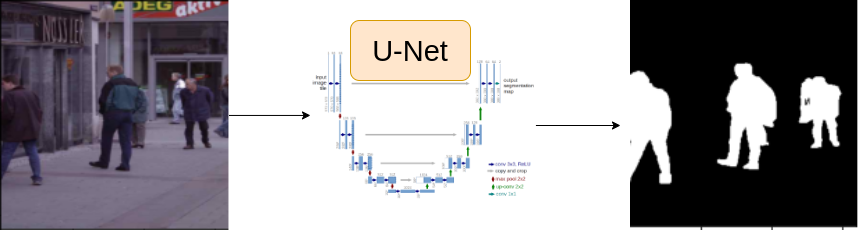

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE ='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR ='/content/'
DEVICE ='cuda'
EPOCHS = 25
LR =0.003
IMG_SIZE = 320
BATCH_SIZE = 16
ENCODER ='timm-efficientnet-b0'
WEIGHTS ='imagenet'

In [ ]:
df = pd.read_csv (CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[0]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE) / 255.0

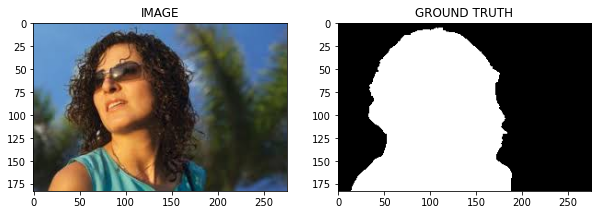

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,valid_df = train_test_split(df,test_size=0.2 , random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose ([
        A.Resize(IMG_SIZE , IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
  ])
def get_valid_augs():
  return A.Compose ([
        A.Resize(IMG_SIZE , IMG_SIZE),
       
  ]) 

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df, augmentations):
    self.df=df
    self.augmentations = augmentations 
  def __len__(self):
    return len(self.df)
  def __getitem__(self ,idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE) #(h,w,c)
    mask =np.expand_dims(mask ,axis=-1)

    if self.augmentations :
      data =self.augmentations(image = image , mask = mask)
      image = data['image']
      mask = data ['mask']

    #(h,w,c) -> (c,h,w)
    image = np.transpose(image ,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask ,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image,mask

In [ ]:
trainset = SegmentationDataset(train_df , get_train_augs())
validset = SegmentationDataset(valid_df , get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


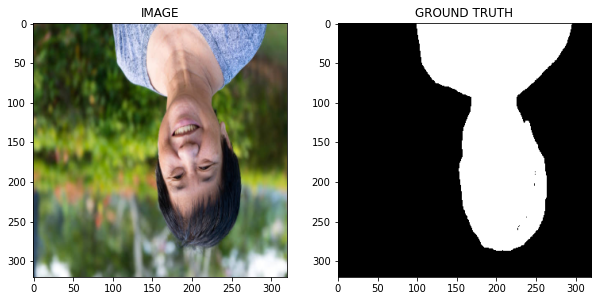

In [ ]:
idx = 3
image ,mask = trainset[idx]
helper.show_image(image , mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset , batch_size =BATCH_SIZE , shuffle =True )
validloader = DataLoader(validset , batch_size =BATCH_SIZE  )

In [ ]:
print(f"total no,of batches in trainloader: {len(trainloader)}")
print(f"total no,of batches in validloader: {len(validloader)}")


total no,of batches in trainloader: 15
total no,of batches in validloader: 4


In [ ]:
for image , mask in trainloader:
  break
print (f'One batch image shape: {image.shape}')
print (f'One batch image shape: {mask.shape}')

One batch image shape: torch.Size([16, 3, 320, 320])
One batch image shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
! pip install segmentation_models_pytorch

In [ ]:
from torch import nn 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel (nn.Module):

  def __init__(self):
    super (SegmentationModel , self).__init__()
    
    self.arc = smp.Unet(
        encoder_name= ENCODER ,
        encoder_weights=  WEIGHTS ,
        in_channels= 3 ,
        classes=  1 ,
        activation = None
    )
  def forward (self ,images ,masks = None):
    logits = self.arc(images)
    
    if masks != None :
      loss1 = DiceLoss(mode='binary')(logits , masks)
      loss2 = nn.BCEWithLogitsLoss()(logits , masks)
      return logits , loss1+loss2
    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn (data_loader , model , optimizer):
  model.train()
  total_loss =0.0

  for images, masks in tqdm(data_loader) :

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits , loss = model(images ,masks)
    loss.backward()
    optimizer.step()

    total_loss +=loss.item()

    return total_loss / len(data_loader)


In [ ]:
def eval_fn (data_loader , model ):

  model.eval()
  total_loss =0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader) :

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits , loss = model(images ,masks)

      total_loss +=loss.item()

  return total_loss / len(data_loader)


# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr= LR)

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader , model , optimizer)
  valid_loss = eval_fn(validloader , model  )

  if valid_loss< best_valid_loss :
    torch.save(model.state_dict(), 'bestModel.pt')
    print ("SAVED")
    best_valid_loss = valid_loss
  print(f"Epoch : {i+1} train_loss :{train_loss} valid_loss :{valid_loss}" )

100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


SAVED
Epoch : 1 train_loss :0.0157505730787913 valid_loss :0.6139251291751862


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


Epoch : 2 train_loss :0.02502369483311971 valid_loss :0.6482116729021072


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


SAVED
Epoch : 3 train_loss :0.025140329202016195 valid_loss :0.5904225558042526


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


SAVED
Epoch : 4 train_loss :0.020455259084701537 valid_loss :0.5429156199097633


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


SAVED
Epoch : 5 train_loss :0.027666171391805012 valid_loss :0.47466210275888443


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


SAVED
Epoch : 6 train_loss :0.020962015787760416 valid_loss :0.4328591227531433


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


SAVED
Epoch : 7 train_loss :0.021670742829640707 valid_loss :0.40284767001867294


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


SAVED
Epoch : 8 train_loss :0.015494908889134724 valid_loss :0.36990829557180405


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


SAVED
Epoch : 9 train_loss :0.01213330626487732 valid_loss :0.3423776887357235


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


SAVED
Epoch : 10 train_loss :0.015272992849349975 valid_loss :0.3072001039981842


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


SAVED
Epoch : 11 train_loss :0.015443507830301921 valid_loss :0.28091393411159515


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


SAVED
Epoch : 12 train_loss :0.01485185424486796 valid_loss :0.278038676828146


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


SAVED
Epoch : 13 train_loss :0.013914541403452555 valid_loss :0.27724703028798103


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


SAVED
Epoch : 14 train_loss :0.019268496831258138 valid_loss :0.2713429480791092


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


SAVED
Epoch : 15 train_loss :0.022041356563568114 valid_loss :0.2649110369384289


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


SAVED
Epoch : 16 train_loss :0.018014983336130778 valid_loss :0.24864809587597847


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


SAVED
Epoch : 17 train_loss :0.020530054966608684 valid_loss :0.24132739752531052


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


SAVED
Epoch : 18 train_loss :0.01877841353416443 valid_loss :0.23735257983207703


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Epoch : 19 train_loss :0.010490673780441283 valid_loss :0.2438804656267166


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Epoch : 20 train_loss :0.021738008658091227 valid_loss :0.2605246342718601


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


Epoch : 21 train_loss :0.014782704909642537 valid_loss :0.28285323828458786


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


Epoch : 22 train_loss :0.01299549142519633 valid_loss :0.29192448407411575


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Epoch : 23 train_loss :0.012812121709187826 valid_loss :0.30438292771577835


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Epoch : 24 train_loss :0.010223740339279174 valid_loss :0.2956486716866493


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

Epoch : 25 train_loss :0.023332548141479493 valid_loss :0.25930243730545044


# Task 9 : Inference

In [ ]:
idx = 2
model.load_state_dict(torch. load('/content/bestModel.pt'))
image, mask = validset[idx]
logits_mask = model (image.to(DEVICE).unsqueeze (0)) #(C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid (logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

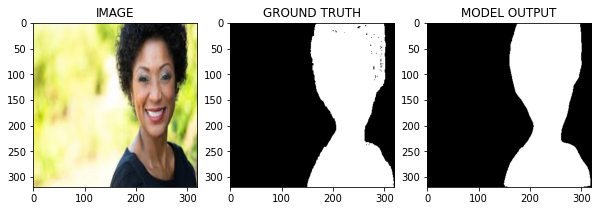

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))